In [6]:
import numpy as np, scipy as sp, pandas as pd
pd.options.display.max_columns = 200
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline
# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
rcParams['font.size'] = 16
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 13
rcParams['ytick.labelsize'] = 13


from toolz.dicttoolz import merge_with

In [3]:
df = pd.read_csv('data/GoT/battles.csv')

<img src="images/winterIsComing.jpg">

<div class="panel panel-info" style="margin: 50px 0 0 0">
    <div class="panel-heading">
        <h3 class="panel-title">Задание 1: Самые агрессивные и самые забитые</h3> 
    </div>
</div>

Постройте <b>bar chart</b>, отражающий количества битв каждой из семей, сначала нарисуйте всех аттакующих, а на другой график поместите защищающихся. Столбцы должны быть отсортированы.
<br><br>
Выясните, кто нападал чаще всех и кому приходилось отбиваться чаще всех.

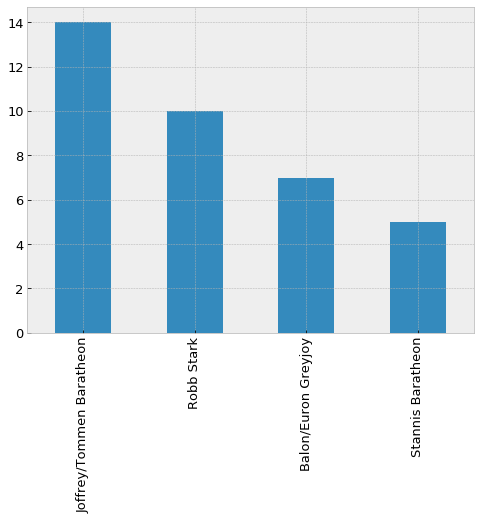

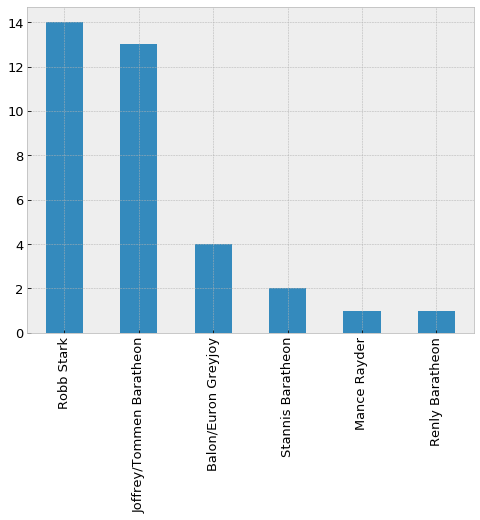

In [4]:
#Выберем для наглядности часть таблицы, где только атакующие и защитники
attDef = df[ ['attacker_king', 'defender_king'] ]

#Отсортируем сначала по attacker_king, внутри attacker_king - по defender_king
attDef = attDef.sort_values(by=['attacker_king', 'defender_king'], ascending=[False, False]);

attDef.attacker_king.value_counts().plot.bar()
f, ax = plt.subplots()
attDef.defender_king.value_counts().plot.bar()

#Итого: самые часто нападающие - Ланистеры, а чаще всего отбивались - Старки

<div class="panel panel-info" style="margin: 50px 0 0 0">
    <div class="panel-heading">
        <h3 class="panel-title">Задание 2: Кто дерется лучше всех?</h3> 
    </div>
</div>

Правильно сосчитайте количество побед и поражений у каждого из королей (__attacker_king__, __defender_king__).

Покажите их статистику как stacked bar plot, отсортировав столбцы по общему количество сражений.

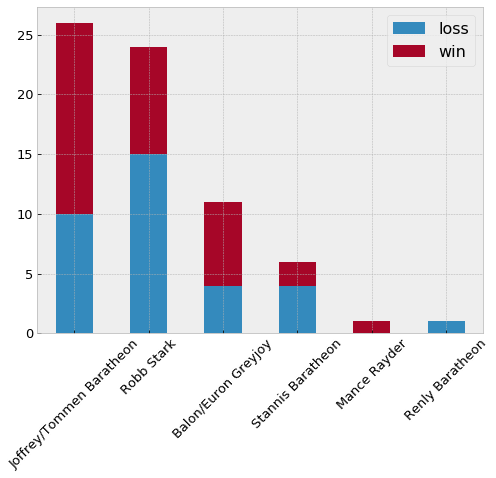

In [12]:
#Выберем для наглядности часть таблицы, где только атакующие и защитники
attDef = df[ ['attacker_king', 'defender_king', 'attacker_outcome'] ]

#Отсортируем сначала по attacker_king, внутри attacker_king - по defender_king
attDef = attDef.sort_values(by=['attacker_king', 'defender_king', 'attacker_outcome'], ascending=[False, False, False])

#######################Победы########################################
#Выберем всех победителей-нападавших
attWin = attDef[ ['attacker_king', 'attacker_outcome'] ]
attWin = attWin[attWin.attacker_outcome == 'win']
attWin = attWin[ ['attacker_king'] ]
attWin = attWin.rename(columns={'attacker_king': 'king'}) #переименуем для дальнейшего объединения
attWin = attWin.drop([22,29]) #Удалим NaN

#Выберем всех победителей-защищавшихся
defWin = attDef[ ['defender_king', 'attacker_outcome'] ]
defWin = defWin[defWin.attacker_outcome == 'loss']
defWin = defWin[ ['defender_king'] ]
defWin = defWin.rename(columns={'defender_king': 'king'}) #переименуем для дальнейшего объединения

#Объединим таблицы (фреймы)
framesWin = [attWin, defWin]
resultWin = pd.concat(framesWin)
#######################Поражения######################################
#Выберем всех Проигравших-нападавших
attLoss = attDef[ ['attacker_king', 'attacker_outcome'] ]
attLoss = attLoss[attLoss.attacker_outcome == 'loss']
attLoss = attLoss[ ['attacker_king'] ]
attLoss = attLoss.rename(columns={'attacker_king': 'king'}) #переименуем для дальнейшего объединения

#Выберем всех Проигравших-защищавшихся
defLoss = attDef[ ['defender_king', 'attacker_outcome'] ]
defLoss = defLoss[defLoss.attacker_outcome == 'win']
defLoss = defLoss[ ['defender_king'] ]
defLoss = defLoss.rename(columns={'defender_king': 'king'}) #переименуем для дальнейшего объединения
defLoss = defLoss.drop([22,29, 24]) #Удалим NaN

#Объединим таблицы (фреймы)
framesLoss = [attLoss, defLoss]
resultLoss = pd.concat(framesLoss)

#########################stacked bar plot#########################
#####################################Ну или проще, да
df['defender_outcome'] = df['attacker_outcome']
df.defender_outcome = df.defender_outcome.map({'win': 'loss', 'loss': 'win'})
merged = merge_with(sum, 
           df.groupby('attacker_king')['attacker_outcome'].value_counts().to_dict(),
           df.groupby('defender_king')['defender_outcome'].value_counts().to_dict())

results = pd.DataFrame(data = merged, index=[0]).stack().fillna(0).transpose()
results.columns = pd.Index(['loss', 'win'])
results['total'] = results.loss + results.win
results.sort_values(by='total', ascending=False, inplace=True)
results[['loss', 'win']].plot(kind='bar', stacked=True, rot=45);

<div class="panel panel-info" style="margin: 50px 0 0 0">
    <div class="panel-heading">
        <h3 class="panel-title">Задание 3: Земля, залитая кровью</h3> 
    </div>
</div>

Представим, что в битве столкнулись отряды в 5000 и 15000 человек. Будем считать потери равными <i>2*min(5000, 15000) = 10000</i>. То есть, грубо говоря, всегда побеждает большинство, но из меньшей армии солдат с собой унесет еще хотя бы одного.

Теперь, зная, как высчитывать потери после боя, выясните, в каком конкретно регионе (__region__) и на какой местности (__location__) полегло больше людишек. Два графика: один - по регионам, второй - по месностям.

Проиллюстрируйте результаты с помощью __pie chart__.

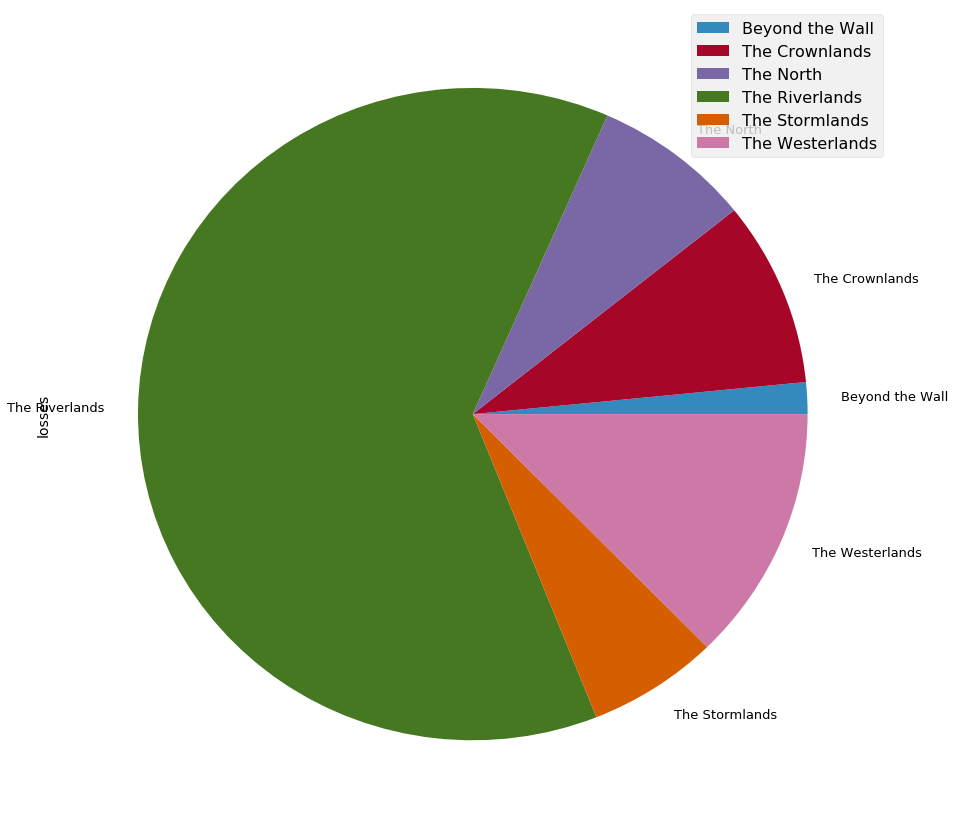

In [13]:
cleaned = df[df.attacker_size.notnull() & df.defender_size.notnull()].copy()
cleaned['losses'] = 2*np.min(np.array([cleaned.attacker_size, cleaned.defender_size]), axis=0)
f,ax = plt.subplots(1,1, figsize=(15, 15));
cleaned.groupby(['region']).agg(sum).plot.pie(y='losses', ax=ax);

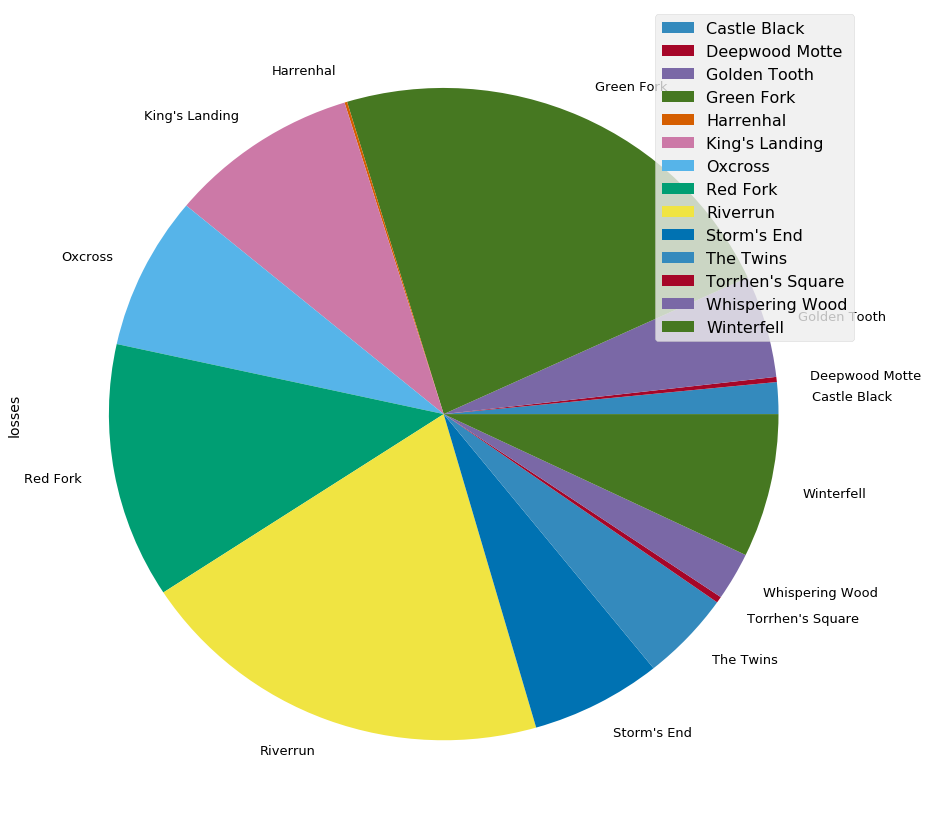

In [14]:
f,ax = plt.subplots(1,1, figsize=(15, 15));
cleaned.groupby(['location']).agg(sum).plot.pie(y='losses', ax=ax);